# PART 1: Car Data Cleaning

---

**GOAL:**  Use Data Analysis to find spot common trends in car data then use this information to help clean and feature engineer the data to assist in accurately predicting the prices of cars. 


## Table of Contents
1. Data Gathering
2. Exploratory Data Analysis (EDA)
3. Cleaning the Data & Dealing with Outliers
4. Feature Engineering & Visualizing Relationships
5. Fitting the Models & Feature Importance
6. References


<br />





## 1. Data Gathering

---

My original plan for this project was to use data collected from one of my previous projects (https://github.com/ryanirl/CraigslistScraper) but rather than spending weeks gathering a large dataset (100k+ entries) I found this dataset (https://www.kaggle.com/austinreese/craigslist-carstrucks-data) on kaggle which has already scrapped some 400k+ entries of data. Huge thanks to Austin Reese who has probably been compiling this data for the last couple of years. If you are following along on your own I would highly recommend downloading this dataset from kaggle as it's to large for me to put on GitHub, though I will most likely have my cleaned data posted to github in a zip file.



In [3]:
# --------- Imports ---------- #
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn
from scipy import stats

# ---- Data Manipulation ----- # 
import category_encoders as ce
from sklearn.model_selection import train_test_split

# ---------- Models ---------- # 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
import lightgbm as lgb

%matplotlib inline

In [4]:
# Reading in the Data
df = pd.read_csv('vehicles.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

<br />

## 2. Exploratory Data Analysis (EDA)

First start by modeling the distribution of the 3 important numeric features we are given (Price, Odometer, and Year). Then we'll model the relationship between certain key categorical features and the numerica features.



<AxesSubplot:xlabel='year', ylabel='Count'>

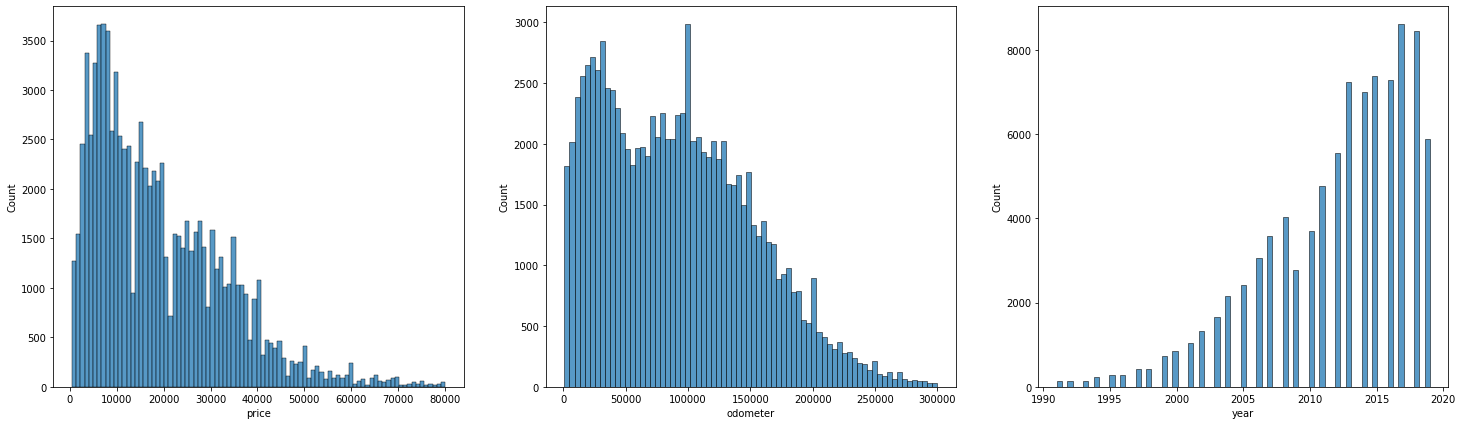

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(25,7))

sample = df[['price', 'year', 'transmission', 'fuel', 'type', 'drive', 'manufacturer', 'title_status', 'odometer']].sample(100000)

sample.price = sample.price[sample.price < 80000][sample.price > 500]
sample.odometer = sample.odometer[sample.odometer < 300000][sample.odometer > 1000]
sample.year = sample.year[sample.year < 2020][sample.year > 1990]

numeric_sample = sample[['price', 'odometer', 'year']]

sb.histplot(sample.price, ax = axes[0])
sb.histplot(sample.odometer, ax = axes[1])
sb.histplot(sample.year, ax = axes[2])


In [27]:
# Restrict the domain even further for this sample data.
sample = sample[sample['year'] > 2010] 

smaller_sample = sample[sample['year'] < 2013] 

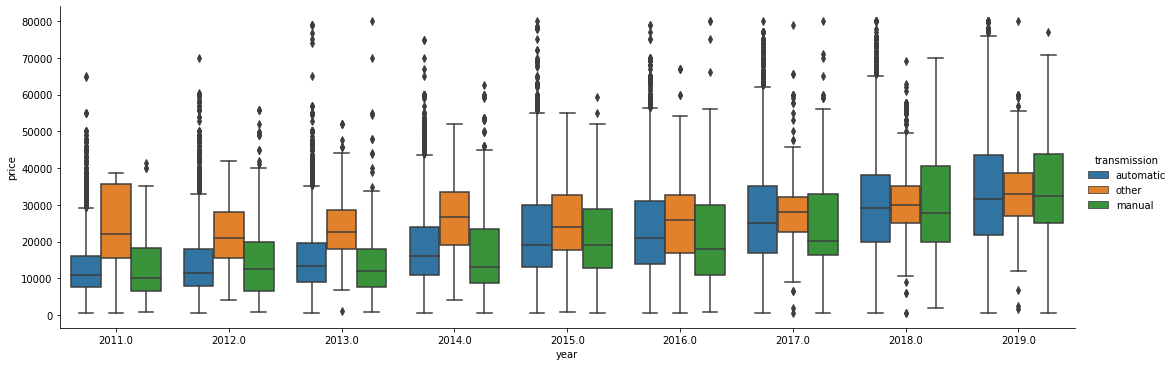

In [28]:
sb.catplot(x = "year", y = "price", hue = "transmission", kind = "box", data = sample, height = 5, aspect = 3)

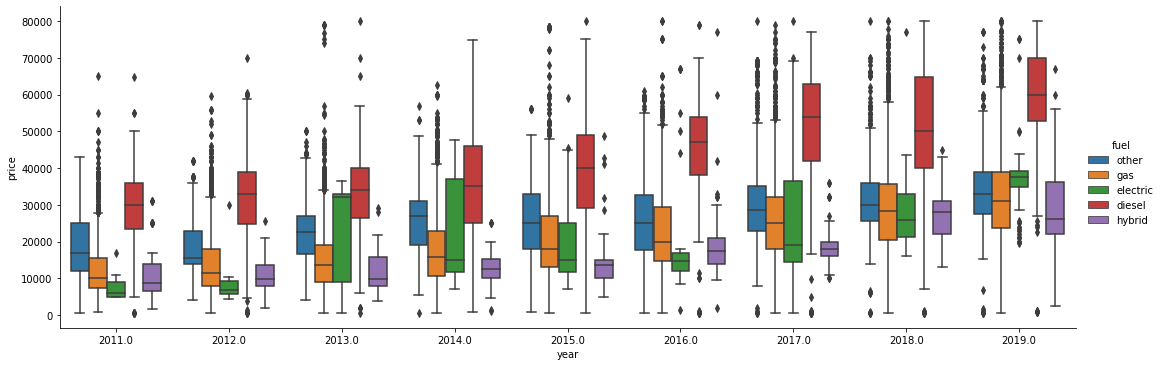

In [29]:
sb.catplot(x = "year", y = "price", hue = "fuel", kind = "box", data = sample, height = 5, aspect = 3)

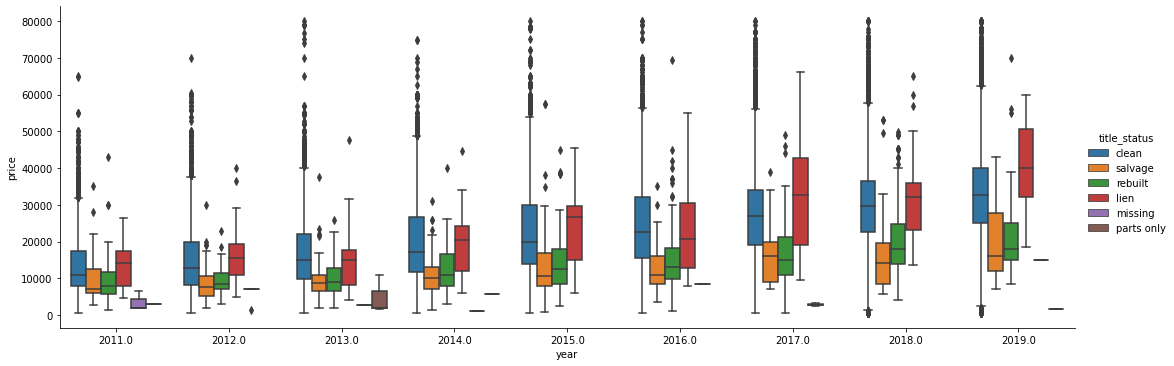

In [30]:
sb.catplot(x = "year", y = "price", hue = "title_status", kind = "box", data = sample, height = 5, aspect = 3)

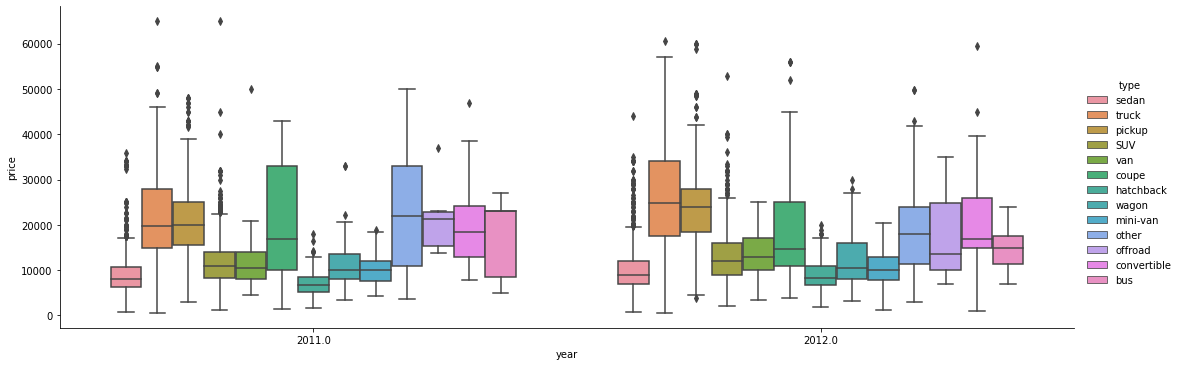

In [31]:
sb.catplot(x = "year", y = "price", hue = "type", kind = "box", data = smaller_sample, height = 5, aspect = 3)

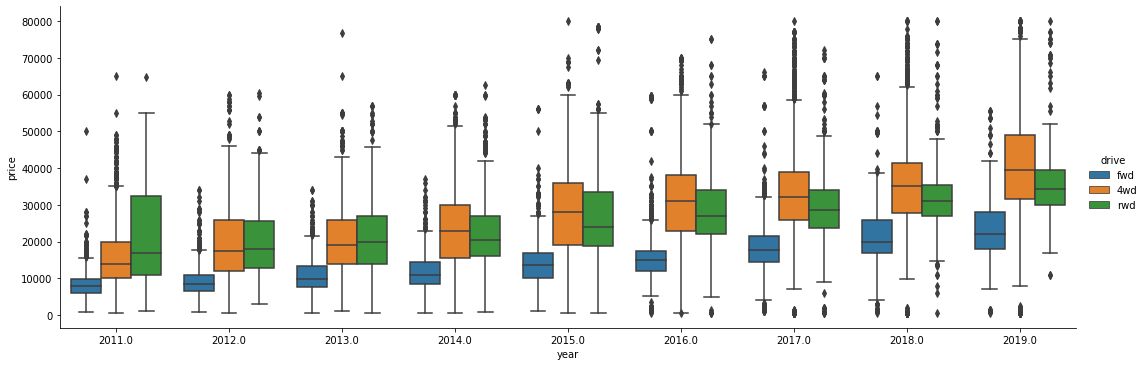

In [32]:
sb.catplot(x = "year", y = "price", hue = "drive", kind = "box", data = sample, height = 5, aspect = 3)

<AxesSubplot:xlabel='price', ylabel='manufacturer'>

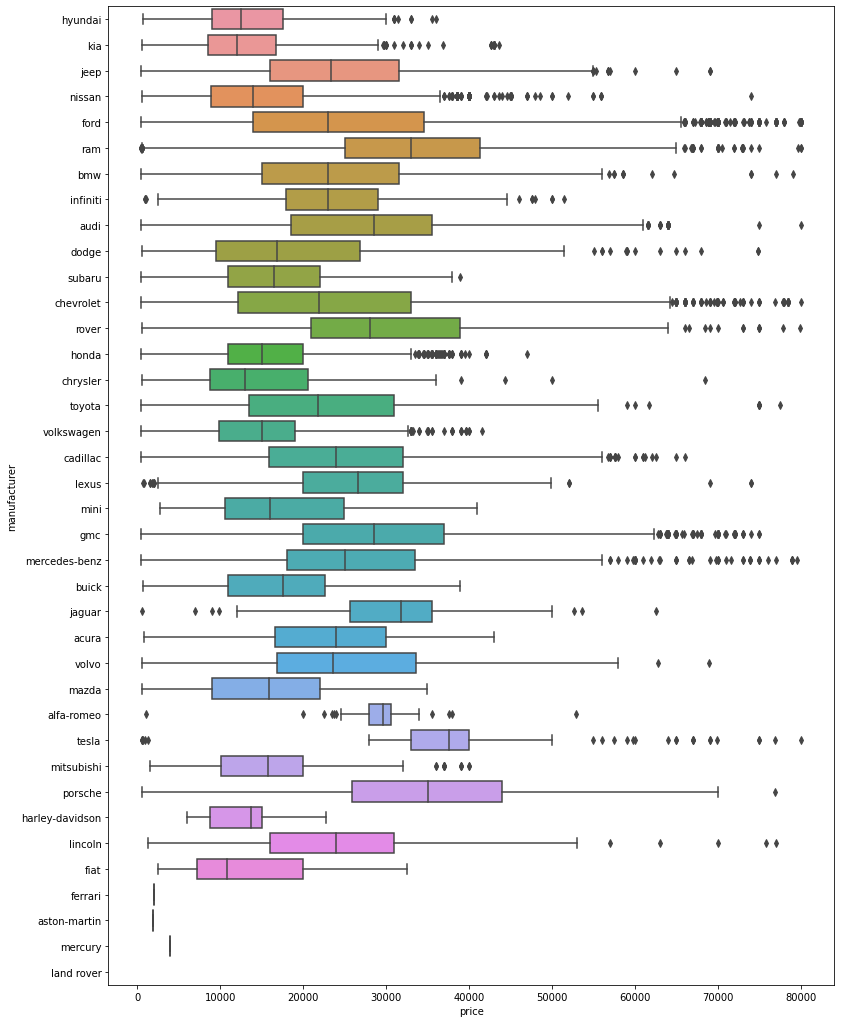

In [33]:
# sb.catplot(x="price", y="manufacturer", hue="manufacturer", kind="box", data=type_data, height=10, aspect=2, notch=True)
fig, ax = plt.subplots(1, 1, figsize = (13, 18))

sb.boxplot(x = 'price', y = 'manufacturer', data = sample)

<br />

## Some Observations

---

From this information we can make the following observations: 



<br />

## Understanding the Features

---

Counting the number of times certain values appear in each feature we come up with the following:





<img src="img/features.png"> 



### Analysing These Values.

---

One key theme that I am going to repeat through this process is the idea that we want CAR data. Data for cars that salvaged and are not motorcycle or bus data. I made this realization after reading this Kaggle post: https://www.kaggle.com/nataliadelarosa/car-dataset-eda-price-prediction/data which was a huge help in this part of the cleaning. So huge shout out to this post. 

**Manufacturer:** Instantly we can see that we need to remove any "harley-davidson" values because it is a motorcylce brand. On top of that I am also going to remove the "morgan" and "datsun" brand simply because they are smaller brands and their value count is rather small.

**Title Status:** Becuase of how large the "clean" title status subset is I am going to remove all of the other features because of the added complexity. Then because I have removed all values but one, I can actually just remove the whole feature (after I remove the other values that is)
    
**Type**: Becuase we are only looking for car data, I am going to remove "other", "offroad", and "bus" types.

**Model:** Because I am trying to keep the data consitance I am going to remove any models with less than 5 occurances. This is not something I have optimized, so if you want to optimize the R2 Score I bet this is something you could play around with.

**Condition:** For the same reasoning as "Title Status" I am going to remove any "salvage" cars.

**Cylinders:** For consistancy I am going to remove any cylinders that classify as "other"

In [5]:
# LOOKING FOR OUTLIERS - EXPLAIN HOW I DID THIS

df = df[~df['title_status'].isin(['salvage', 'parts only', 'missing', 'lien', 'rebuilt'])]
df = df[~df['type'].isin(['other', 'offroad', 'bus'])]
df = df[~df['condition'].isin(['salvage'])]
df = df[~df['manufacturer'].isin(['morgan', 'datsun', 'harley-davidson'])]

counts = df['model'].value_counts()

temp = df[~df['model'].isin(counts[counts < 5].index)]

len(df.index)

389922

<br />

## 3. Cleaning the Data & Dealing with Outliers

---

Of the 25 features included in the dataset we are only interested in features with strong correlation to price. It's easy to see that - **posting_date, county, image_url, region_url, region_url, description, id, url, region, VIN, long, and lat** - won't have a strong correlation to the price and can therefore be removed.

In addition, becuase I removed all but one values in the **title status** feature I can also remove that. This leaves us with 13 Key Features.


### Important Features of the Dataset:

**Numeric Features:**
- Price           
- Year  
- Odometer



**Categorical Features:**

Nominal:
- Manufacturer 
- Type 
- Paint Color
- Transmission
- Drive
- Fuel
- State

Ordinal:
- Condition                         
- Cylinders           
- Size               


---



In [6]:
# List of "Bad Features" whos values aren't correlated with price. 

# add back model
bad_features = ['posting_date', 'county', 'image_url', 'region_url', 'region_url', 'description',
                'id', 'url', 'region', 'VIN', 'long', 'lat', 'title_status']

# Remeving these bad features from out Dataset.
df.drop(bad_features, inplace=True, axis=1)





## Outliers

---

When dealing with automobile data from Craiglist we are ought to get many outliers because it's prone to human error. For example, look at the code below, the vanilla Dataset has 30,000+ rows with cars listed at 0 dollars, so I am going to restrict most of the inherently numeric features domains in order to help with these outliers.



In [46]:
df.price.value_counts().head()

0       30477
6995     3016
7995     2953
9995     2700
8995     2676
Name: price, dtype: int64

<br />

---


To start, we have 3 numeric features in which human error can introduct outliers. These features are Price, Odometer, and Year. To simplify our data and remove outliers I could do something like finding the z-score of each feature then remove outliers that way, but because of the sheere number of outliers I believe we have, the z-score itself (and other techniques) will be bais towards these outliers.

**Solution:** The easiest way around this is just to restrict the domains themself.



In [7]:
# Removing any cars that don't have price between 500 < x < 80000
df = df[df['price'] > 500]
df = df[df['price'] < 80000] 

# Removing any cars that don't have odometer between 500 < x < 300000
df = df[df['odometer'] < 300000]
df = df[df['odometer'] > 500]

# Removing any cars that don't have year between 2020 < x < 2000
df = df[df['year'] < 2020]
df = df[df['year'] > 2000]

len(df.index)

299313

<br />


We have removed over 100,000 entries which lie beyond this domain restriction.



## NaN Values

---

Rather than imputing values, because of the amount of data we have I am just going to drop any NaN values we have in the subet containing "odometer", "cylinders", "manufacturer", and "model" then fill the rest of the NaN values with 0. 



In [8]:
# Dropping NaN values actually increased the R2 Score by roughly 5%.

df.dropna(subset = ["odometer", "cylinders", "manufacturer", "model"], inplace=True)

df.fillna("0", inplace=True)

len(df.index)

173174

<br />

## 4. Feature Engineering

---

There are 11 categorical features that need to be represented numerically. I will use Target Encoding to Encode out features.


In [9]:
Y = df['price']

df.drop('price', inplace=True, axis=1)

In [10]:
# Learned about Target Encoding here: https://towardsdatascience.com/stop-one-hot-encoding-your-categorical-variables-bbb0fba89809

# ------------- Target Encoding ----------------- #

# Complies Target Encoding for Features (NOT INCLUDING "Manufacturer")
target_encode = ce.TargetEncoder(cols = ['transmission', 'fuel', 'type', 'drive', 'state', 'condition', 
                                         'size', 'cylinders', 'paint_color', 'model', 'manufacturer']).fit(df, Y)

# Applies Target Endcoding and Transforms Dataframe
df = target_encode.transform(df)



# ------------- One-Hot Encoding ---------------- #

# Builds One-Hot Encoding 
# one_hot_encoding = pd.get_dummies(df.manufacturer)

# Drops Categorical Manufactural Feature
# df.drop('manufacturer', inplace=True, axis=1)

# Adds One-Hot Encoding of Manufacturers to Dataframe
# df = pd.concat([df, one_hot_encoding], axis=1)

/usr/local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):




## Normalizing & Saving the Data

---

The following code was not run when I ran my tests simply because they did not improve my results (or harm them). If you would like to save your data you can run the first cell. If you would like to normalize the whole dataset you can run the second cell.



In [11]:
# normalized_df = pd.DataFrame(stats.zscore(df))
# normalized_df.to_csv('normalized_cleaned_vehicles.csv')

df.to_csv('cleaned_features.csv')
Y.to_csv('cleaned_targets.csv')

In [43]:
df = stats.zscore(df)

<br />

## 5. Predicting and Feature Importance

---


The models I will be testing out are:
 - Random Forest Regressor
 - K Nearest Regressor
 - XGBoost Regressor
 - Linear Regression
 - Logistic Regression ( crashes for some reason ??? )
 - LightGBM Regressor

In [51]:
# To show accuracy of Models. R2 Score and MAE will be how I evaluate the accuracy.
def accuracy(test_actual, test_predicted, model):
    print("MAE Score : {} | {}".format(sklearn.metrics.mean_absolute_error(test_actual, test_predicted), model))
    print("R2 Score  : {} | {}".format(sklearn.metrics.r2_score(test_actual, test_predicted), model))

# Splitting the Data.
X_train, X_test, y_train, y_test = train_test_split(df, Y, train_size=0.90, test_size=0.1, random_state=42)

test = y_test.to_numpy()

### 1. Random Forest



In [52]:
# RANDOM FOREST

RFR_model = RandomForestRegressor(random_state = 1) 

RFR_model.fit(X_train, y_train)

results = RFR_model.predict(X_test)

accuracy(test, results, "Random Forest Regressor")

MAE Score : 1570.1255731671752 | Random Forest Regressor
R2 Score  : 0.9314103196926281 | Random Forest Regressor


### 2. K-Neighbors Regressor



In [53]:
# K-Nearest-Regressor

KNR_model = KNeighborsRegressor(n_neighbors=5)

KNR_model.fit(X_train, y_train)

results = KNR_model.predict(X_test)

accuracy(test, results, "K-Nearest-Regressor")

MAE Score : 2980.417611733457 | K-Nearest-Regressor
R2 Score  : 0.828639063796793 | K-Nearest-Regressor


### 3. Linear Regression



In [54]:
# Linear Regression

LR_model = LinearRegression()

LR_model.fit(X_train, y_train)

results = LR_model.predict(X_test)

accuracy(test, results, "Linear Regression")

MAE Score : 3989.4625037609067 | Linear Regression
R2 Score  : 0.7935019643493944 | Linear Regression


### 4. XGBoost Regressor



In [55]:
# XGBoost Regressor

XGBR_model = xgb.XGBRegressor()

XGBR_model.fit(X_train, y_train)

results = XGBR_model.predict(X_test)

accuracy(test, results, "XGBRegressor")

MAE Score : 2393.8990097833375 | XGBRegressor
R2 Score  : 0.9004797677949954 | XGBRegressor


### 5. LightGBM Regressor



In [56]:
# LightGBM Regressor
LGBM_model = lgb.LGBMRegressor()

LGBM_model.fit(X_train, y_train)

results = LGBM_model.predict(X_test)

accuracy(test, results, "LGBMRegressor")

MAE Score : 2632.3006531472633 | LGBMRegressor
R2 Score  : 0.8848692476842355 | LGBMRegressor


### Scores:

<br />

| Model | R2 Score | MAE Score |
| --- | --- | --- |
| Random Forest Regressor | 1570.125 | 0.931 |
| XGBoost Regressor | 2368.176 | 0.902 |
| LightGBM Regressor | 2629.613 | 0.886 |
| K-Nearest Regressor | 2973.658 | 0.829 |
| Linear Regression | 3989.318 | 0.794 |

<br />

We can see that Random Forest Regressor clearly performed the best with an R2 Score of 0.931!


<br />

### Analysing Feature Importance

---



<AxesSubplot:title={'center':'Random Forest Regressor Features'}>

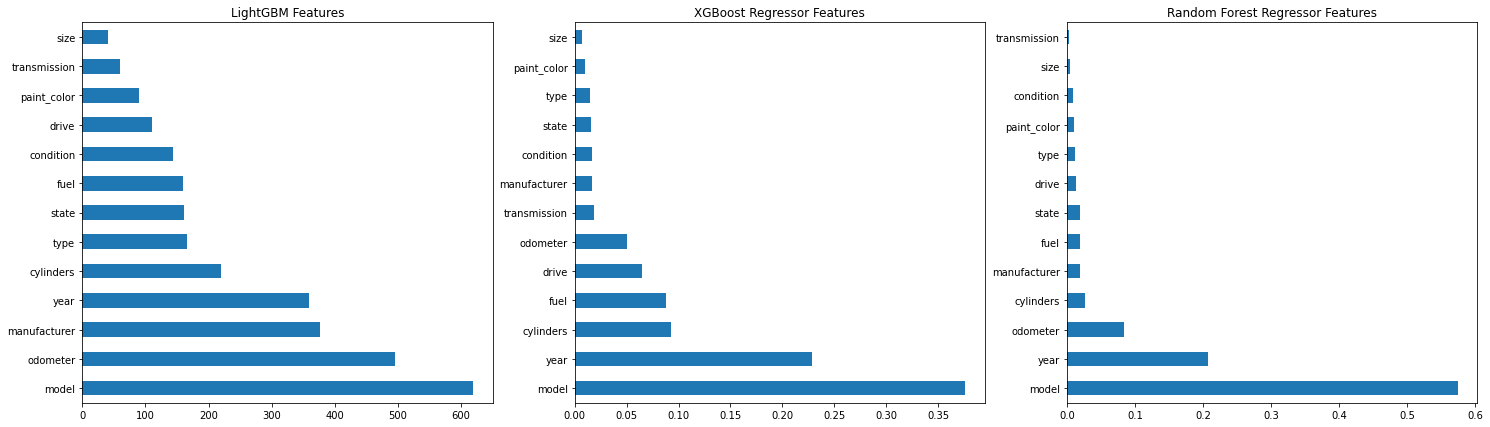

In [57]:
# Learned about this trick from https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d-abnormals-filter

fig, axes = plt.subplots(1, 3, figsize=(25,7))

LGBM_plot = pd.Series(LGBM_model.feature_importances_, index = df.columns)
XGBR_plot = pd.Series(XGBR_model.feature_importances_, index = df.columns)
RFR_plot = pd.Series(RFR_model.feature_importances_, index = df.columns)

LGBM_plot.nlargest(25).plot(kind="barh", ax=axes[0], title = "LightGBM Features")
XGBR_plot.nlargest(25).plot(kind="barh", ax=axes[1], title = "XGBoost Regressor Features")
RFR_plot.nlargest(25).plot(kind="barh", ax=axes[2], title = "Random Forest Regressor Features")

It's interesting to see how different models work. It's clear that the decision trees outperform other methods (particularly Random Forest in this case), aside from model, each model differered quick large in what it found most important.

In [110]:
# If your interested in a correlation map of each feature.
# fig, axes = plt.subplots(figsize = (20, 15))

# sb.heatmap(df.corr(), annot = True, linewidths = 0.5, ax = axes)

<br />

## References:

---

- (1): Got a lot of data cleaning ideas from here. Huge shout out to this post: https://www.kaggle.com/nataliadelarosa/car-dataset-eda-price-prediction/data

- (2): Data from kaggle found here: https://www.kaggle.com/austinreese/craigslist-carstrucks-data

- (3): Great example of a data analysis notebook: https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb

- (4): Learned out feature_importance_ feature from here: https://www.kaggle.com/vbmokin/used-cars-fe-eda-with-3d-abnormals-filter

- (5): Learned about Target Encoding for this project from this blog post: https://towardsdatascience.com/stop-one-hot-encoding-your-categorical-variables-bbb0fba89809